In [1]:
!pip install scipy==1.8.0
!pip install texttable


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
import statistics
import numpy as np
import math
import collections
import scipy
from texttable import Texttable

In [35]:
NUM_OF_GRAPHS = 5
NUM_OF_NODES = 80

# Creating Graphs

In [36]:
def create_random_graph(n=100, p=0.04):
    return nx.erdos_renyi_graph(n, p)


def create_small_world_ws_graph(n=100, p=0.35, m=4):
    return nx.watts_strogatz_graph(n, m, p)


def create_small_world_nws_graph(n=100, p=0.35, k=4):
    return nx.newman_watts_strogatz_graph(n, k, p)


def create_agave_graph(n=100, steps=1):
    G = nx.Graph()
    G.add_nodes_from([x for x in range(n)])
    if steps < 0:
        steps = 0
    elif steps >= n:
        steps = n-1;
    for i in range(steps+1):
        for j in range(i+1, n):
            G.add_edge(i,j)
    return G


def create_scale_free_graph(n=100, gamma=2):
    seq = nx.utils.powerlaw_sequence(n, gamma) #100 nodes, power-law exponent 2.5
    G = nx.expected_degree_graph(seq, selfloops=False)
    return G

# Read and Write to File

In [37]:
def write_list_to_file(file_name, floats):
    with open(("outputs/" + file_name), "w") as f:
        f.write("\n".join(map(str, floats)))
        
def read_list_from_file(file_name):
    with open("outputs/" + file_name, "r") as f:
        content = f.read()
        floats = list(map(float, content.split()))
    return floats

# Main Functions

In [38]:
def get_average_degree(G):
    return sum(G.degree(v) for v in G.nodes()) / G.number_of_nodes()

In [39]:
def get_average_path_length(G):
    connected_components = (G.subgraph(c) for c in nx.connected_components(G))
    average_paths = []
    for component in connected_components:
        average_paths.append(nx.average_shortest_path_length(component))
    return statistics.mean(average_paths)

In [40]:
def get_propagation_ratio(K, n, L=6):
    # n = G.number_of_nodes()
    # K = get_average_degree(G)
    return n / math.pow(K,L)
    

def get_Cp_analytic(K, rewiring):
    # K = get_average_degree(G)
    p = rewiring
    return (3*K-6)/(4*K-2)*((1-p)**3)


def get_Fx(x):
    return 1/(2*math.sqrt((x**2)+(2*x)))*np.arctanh(math.sqrt(x/(x+2)))


def get_Lp(K, rewiring, n):
    # n = G.number_of_nodes()
    # K = get_average_degree(G)
    p = rewiring
    return 2*n/K*get_Fx(n*K*p/2)

In [41]:
# Rn is the number of available paths from i_0 to i_n with distinct nodes
def calculate_Rn(n, adjacency_matrix, i_0, i_n):
    # indices = [range(len(adjacency_matrix)) for x in range(n-1)]
    s = 0
    if n == 2:
        for a in range(len(adjacency_matrix)):
            if adjacency_matrix[i_0][a] and adjacency_matrix[a][i_n]:
                s += 1
    if n == 3:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][i_n]:
                    s += 1
    elif n == 4:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][i_n]:
                        s += 1
    elif n == 5:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    for d in range(c+1, len(adjacency_matrix)):
                        if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][d] and adjacency_matrix[d][i_n]:
                            s += 1
    elif n == 6:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    for d in range(c+1, len(adjacency_matrix)):
                        for e in range(d+1, len(adjacency_matrix)):
                            if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][d] and adjacency_matrix[d][e] and adjacency_matrix[e][i_n]:
                                s += 1
    return s


def get_Cp(G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    Rn = [[x] for x in list(G)]
    sumds = [0]
    sumns = []
    cycle_nodes = []
    for i in range(1,6):
        Rn_new = []
        sumn = 0
        cycle_nodes.append(set([]))
        for path in Rn:
            for neighbor in list(G[path[-1]]):
                if neighbor in path[1:]:
                    continue
                if neighbor == path[0]:
                    sumn += 1
                    for node in path:
                        cycle_nodes[i-1].add(node)
                else:
                    Rn_new.append(path + [neighbor])
        Rn = Rn_new
        sumd = len(Rn_new)
        sumns.append(sumn)
        sumds.append(sumd)
        # sumds[i-1] += sumn
    #C6
    sumn = 0
    cycle_nodes.append(set([]))
    for path in Rn:
        if path[0] in G[path[-1]]:
            sumn += 1
            for node in path:
                cycle_nodes[5].add(node)
    sumns.append(sumn)
    # sumds[5] += sumn

    Cps = []
    for i in range(3,7):
        if sumds[i-1] == 0:
            Cps.append(0)
        else:
            Cps.append(sumns[i-1]/sumds[i-1])
    return Cps, sumds[2:], sumns[2:]


def calculate_Sq_old(G, q):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    sum_numerator = 0
    sum_denominator = 0
    for i in range(len(adjacency_matrix)):
        for j in range(i, len(adjacency_matrix)):
            if i == j:
                sum_numerator += calculate_Rn(q, adjacency_matrix, i, i)
            else:
                sum_denominator += calculate_Rn(q-1, adjacency_matrix, i, j)
    return sum_numerator, sum_denominator


def get_Cp_old(G, p):
    sum_numerator, sum_denominator = calculate_Sq_old(G,q)
    return sum_numerator/(sum_denominator+sum_numerator)

In [42]:
def get_degree_variance(G):
    return statistics.variance([x[1] for x in list(G.degree())])


def get_degree_entropy(G):
    degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
    degrees = collections.Counter(degree_sequence)
    sum_degrees = sum(degrees.values())
    return (-1) * sum((degrees[k] * math.log(degrees[k]/sum_degrees)) for k in degrees) / sum_degrees

In [43]:
def get_rn_and_tn(n, G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    np_matrix = np.array(adjacency_matrix)
    new_matrix = np_matrix
    rns = []
    tns = []
    rn = np.count_nonzero(new_matrix) / (len(adjacency_matrix)**2)
    rns.append(rn)
    tns.append(rn)
    for i in range(1,n):
        new_matrix = np.matmul(new_matrix, np_matrix)
        rn = np.count_nonzero(new_matrix) / (len(adjacency_matrix)**2)
        rns.append(rn)
        tns.append(rn + tns[i-1])
    return rns, tns

In [44]:
def get_regression_line(x, y):
    b, a = np.polyfit(x, y, deg=1)
    xnp = np.array(x)
    linenp = a + b * xnp
    return linenp.tolist()

In [45]:
def get_hamming_coeff(G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    hsum = 0
    n = len(adjacency_matrix)
    for i in range(n):
        for j in range(i+1, n):
            hsum += sum([adjacency_matrix[i][x]*adjacency_matrix[j][x] for x in range(n)])
    h = hsum * 2 / (n * (n-1))
    return h

# n, Cp, average path, R

In [46]:
alphas = [0.1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
nns = [x for x in range(1,11)]
qs = [3,4,5,6]
cs = [[] for x in range(len(qs))]
ss = [[] for x in range(len(qs))]
rns = [[] for x in range(len(nns))]
tns = [[] for x in range(len(nns))]
cycles = [[] for x in range(len(qs))]
hcs = []
ds = []
rs = []
vs = []
es = []
for a in alphas:
    csums = [0 for x in range(len(qs))]
    ssums = [0 for x in range(len(qs))]
    tsums = [0 for x in range(len(nns))]
    rsums = [0 for x in range(len(nns))]
    cycles_sums = [0 for x in range(len(qs))]
    hcsum = 0
    dsum = 0
    rsum = 0
    vsum = 0
    esum = 0
    print(a)
    for j in range(NUM_OF_GRAPHS):
        G = create_scale_free_graph(NUM_OF_NODES, a)
        cps, sps, cycles_temp = get_Cp(G)
        rns_temp, tns_temp = get_rn_and_tn(10, G)
        dsum += get_average_path_length(G)
        rsum += get_propagation_ratio(4,NUM_OF_NODES)
        vsum += get_degree_variance(G)
        esum += get_degree_entropy(G)
        hcsum += get_hamming_coeff(G)
        for i in range(len(qs)):
            csums[i] += cps[i]
            ssums[i] += sps[i]
            cycles_sums[i] += cycles_temp[i] / ((i+3)*2)
        for i in range(len(nns)):
            tsums[i] += tns_temp[i]
            rsums[i] += rns_temp[i]
    for i in range(len(qs)):
        cs[i].append(csums[i]/NUM_OF_GRAPHS)
        ss[i].append(ssums[i]/NUM_OF_GRAPHS)
        cycles[i].append(cycles_sums[i]/NUM_OF_GRAPHS)
    for i in range(len(nns)):
        rns[i].append(rsums[i]/NUM_OF_GRAPHS)
        tns[i].append(tsums[i]/NUM_OF_GRAPHS)
    ds.append(dsum/NUM_OF_GRAPHS)
    rs.append(rsum/NUM_OF_GRAPHS)
    vs.append(vsum/NUM_OF_GRAPHS)
    es.append(esum/NUM_OF_GRAPHS)
    hcs.append(hcsum/NUM_OF_GRAPHS)

0.1


C:\Users\WebVajhegan\AppData\Local\Temp\ipykernel_10148\2788784867.py:39: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G).toarray()
C:\Users\WebVajhegan\AppData\Local\Temp\ipykernel_10148\1978197803.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G).toarray()


1.5
2
2.5
3
3.5
4
4.5
5


In [15]:
t = Texttable()
t.add_row(['gamma'] + [f'gamma={x}' for x in alphas])
t.add_row(['C3'] + [f'{x:4f}' for x in cs[0]])
t.add_row(['C4'] + [f'{x:4f}' for x in cs[1]])
t.add_row(['C5'] + [f'{x:4f}' for x in cs[2]])
t.add_row(['C6'] + [f'{x:4f}' for x in cs[3]])
t.add_row(['<d>'] + [f'{x:4f}' for x in ds])
t.add_row(['R'] + [f'{x:4f}' for x in rs])
print(t.draw())

+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
| gamma | gamma | gamma | gamma | gamma | gamma | gamma | gamma | gamma | gamm |
|       | =0.1  | =1.5  | =2    | =2.5  | =3    | =3.5  | =4    | =4.5  | a=5  |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
| C3    | 0.035 | 0.173 | 0.162 | 0.114 | 0.045 | 0.039 | 0.025 | 0.018 | 0.00 |
|       |       |       |       |       |       |       |       |       | 9    |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
| C4    | 0     | 0.329 | 0.166 | 0.100 | 0.043 | 0.029 | 0.020 | 0.023 | 0.02 |
|       |       |       |       |       |       |       |       |       | 9    |
+-------+-------+-------+-------+-------+-------+-------+-------+-------+------+
| C5    | 0     | 0.216 | 0.146 | 0.085 | 0.044 | 0.023 | 0.016 | 0.009 | 0.01 |
|       |       |       |       |       |       |       |       |       | 1    |
+-------+-------+-------+---

# Cp / average degree - n

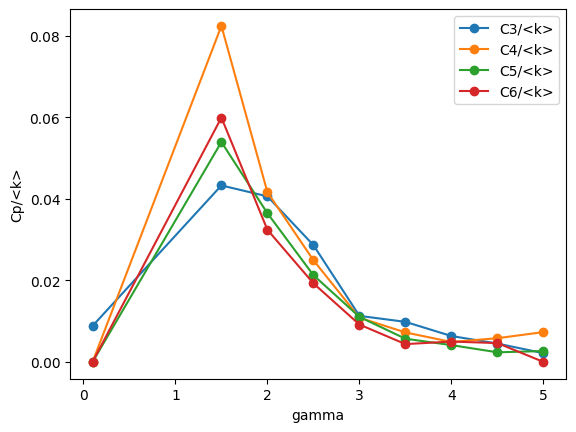

In [16]:
plt.plot(alphas, [x/4 for x in cs[0]], marker='o', label='C3/<k>')
plt.plot(alphas, [x/4 for x in cs[1]], marker='o', label='C4/<k>')
plt.plot(alphas, [x/4 for x in cs[2]], marker='o', label='C5/<k>')
plt.plot(alphas, [x/4 for x in cs[3]], marker='o', label='C6/<k>')
plt.xlabel('gamma')
plt.ylabel('Cp/<k>')
plt.legend()

# log Cp - log n

ValueError: math domain error

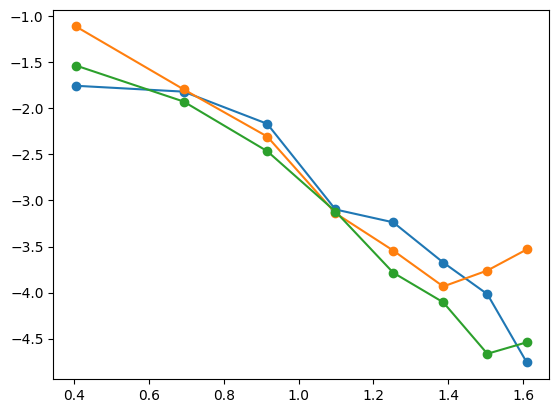

In [17]:
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in cs[0][1:]], marker='o', label='log C3')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in cs[1][1:]], marker='o', label='log C4')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in cs[2][1:]], marker='o', label='log C5')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in cs[3][1:]], marker='o', label='log C6')
plt.xlabel('log gamma')
plt.ylabel('log Cp')
plt.legend()

# Xp - n

[0.03529411764705882, 0.5024308714205292, 0.3287060763953813, 0.2141901178905988, 0.08849309668675279, 0.06817608248146054, 0.044950230123559344, 0.04127380005439282, 0.03783309709980319]


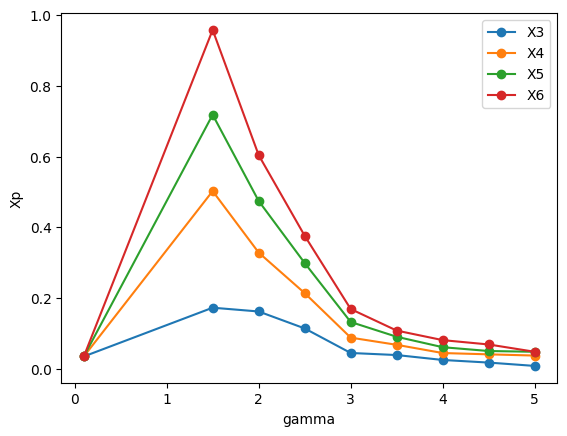

In [18]:
xs = []
xs.append(cs[0])
for i in range(1,4):
    xs.append([])
    for j in range(len(alphas)):
        xs[i].append(xs[i-1][j] + cs[i][j])
print(xs[1])
plt.plot(alphas, xs[0], marker='o', label='X3')
plt.plot(alphas, xs[1], marker='o', label='X4')
plt.plot(alphas, xs[2], marker='o', label='X5')
plt.plot(alphas, xs[3], marker='o', label='X6')
plt.xlabel('gamma')
plt.ylabel('Xp')
plt.legend()

# log Xp - n

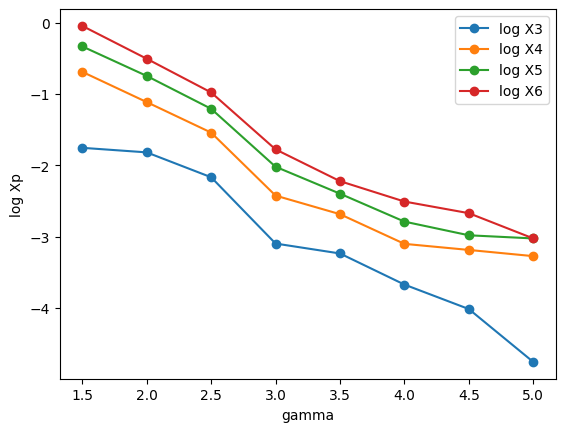

In [19]:
plt.plot(alphas[1:], [math.log(x) for x in xs[0][1:]], marker='o', label='log X3')
plt.plot(alphas[1:], [math.log(x) for x in xs[1][1:]], marker='o', label='log X4')
plt.plot(alphas[1:], [math.log(x) for x in xs[2][1:]], marker='o', label='log X5')
plt.plot(alphas[1:], [math.log(x) for x in xs[3][1:]], marker='o', label='log X6')
plt.xlabel('gamma')
plt.ylabel('log Xp')
plt.legend()

# log Xp - log n

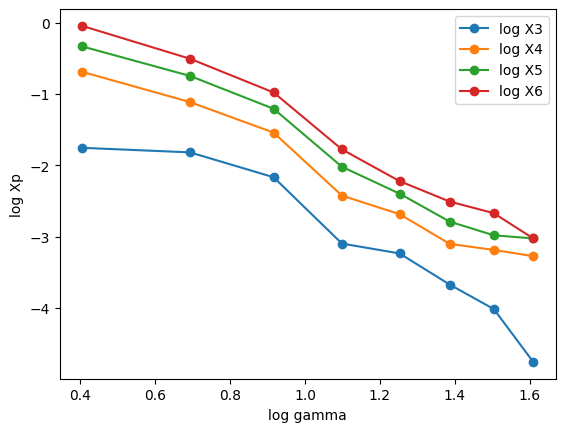

In [20]:
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in xs[0][1:]], marker='o', label='log X3')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in xs[1][1:]], marker='o', label='log X4')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in xs[2][1:]], marker='o', label='log X5')
plt.plot([math.log(x) for x in alphas[1:]], [math.log(x) for x in xs[3][1:]], marker='o', label='log X6')
plt.xlabel('log gamma')
plt.ylabel('log Xp')
plt.legend()

# Mq - n

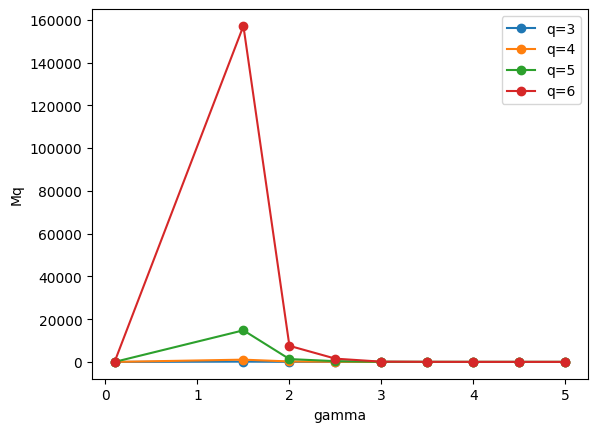

In [21]:
ms = []
for j in range(0,4):
    ms.append([ss[j][i]/NUM_OF_NODES for i in range(len(alphas))])
plt.plot(alphas, ms[0], marker='o', label='q=3')
plt.plot(alphas, ms[1], marker='o', label='q=4')
plt.plot(alphas, ms[2], marker='o', label='q=5')
plt.plot(alphas, ms[3], marker='o', label='q=6')
plt.xlabel('gamma')
plt.ylabel('Mq')
plt.legend()

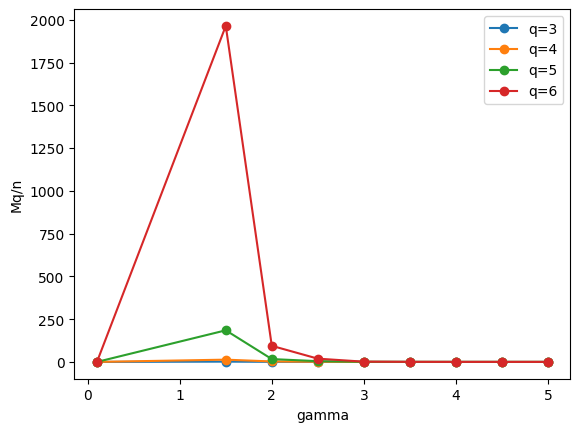

In [22]:
ms = []
for j in range(0,4):
    ms.append([ss[j][i]/(NUM_OF_NODES ** 2) for i in range(len(alphas))])
plt.plot(alphas, ms[0], marker='o', label='q=3')
plt.plot(alphas, ms[1], marker='o', label='q=4')
plt.plot(alphas, ms[2], marker='o', label='q=5')
plt.plot(alphas, ms[3], marker='o', label='q=6')
plt.xlabel('gamma')
plt.ylabel('Mq/n')
plt.legend()

# log Mq - n

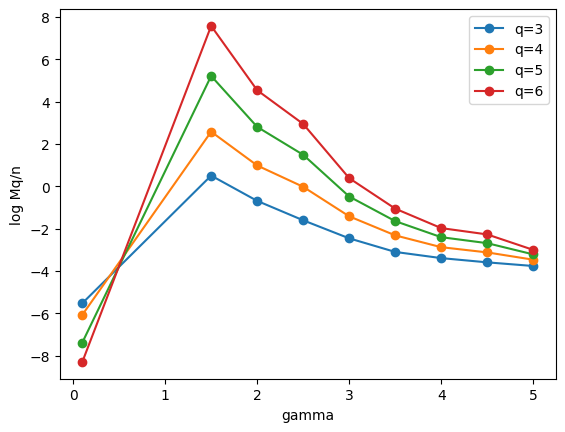

In [23]:
plt.plot(alphas, [math.log(x) for x in ms[0]], marker='o', label='q=3')
plt.plot(alphas, [math.log(x) for x in ms[1]], marker='o', label='q=4')
plt.plot(alphas, [math.log(x) for x in ms[2]], marker='o', label='q=5')
plt.plot(alphas, [math.log(x) for x in ms[3]], marker='o', label='q=6')
plt.xlabel('gamma')
plt.ylabel('log Mq/n')
plt.legend()

# log Mq - log n

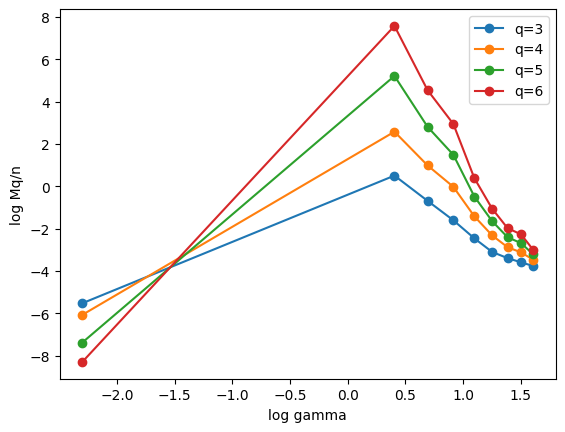

In [24]:
plt.plot([math.log(x) for x in alphas], [math.log(x) for x in ms[0]], marker='o', label='q=3')
plt.plot([math.log(x) for x in alphas], [math.log(x) for x in ms[1]], marker='o', label='q=4')
plt.plot([math.log(x) for x in alphas], [math.log(x) for x in ms[2]], marker='o', label='q=5')
plt.plot([math.log(x) for x in alphas], [math.log(x) for x in ms[3]], marker='o', label='q=6')
plt.xlabel('log gamma')
plt.ylabel('log Mq/n')
plt.legend()

# degree variace - n

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


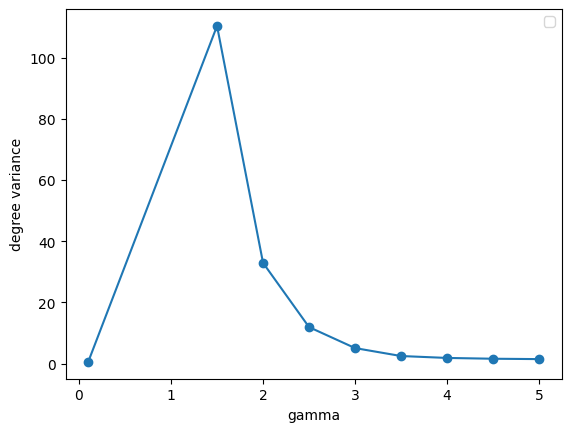

In [25]:
plt.plot(alphas, vs, marker='o')
plt.xlabel('gamma')
plt.ylabel('degree variance')
plt.legend()

# degree entropy - n

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


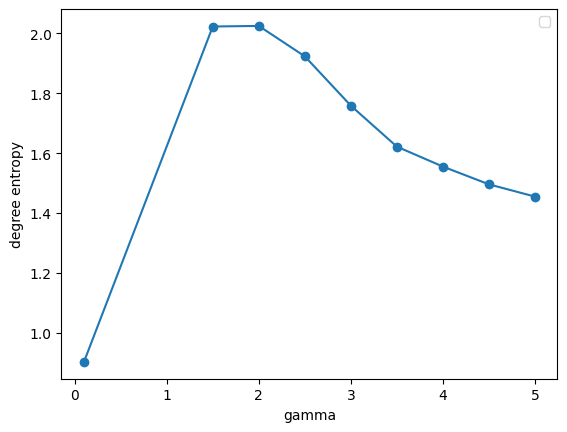

In [26]:
plt.plot(alphas, es, marker='o')
plt.xlabel('gamma')
plt.ylabel('degree entropy')
plt.legend()

# rn - n

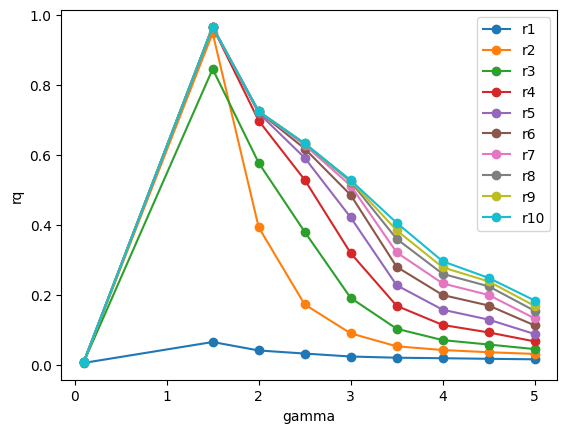

In [27]:
for i in nns:
    plt.plot(alphas, rns[i-1], marker='o', label=f'r{i}')
plt.xlabel('gamma')
plt.ylabel('rq')
plt.legend()

# Tn - n

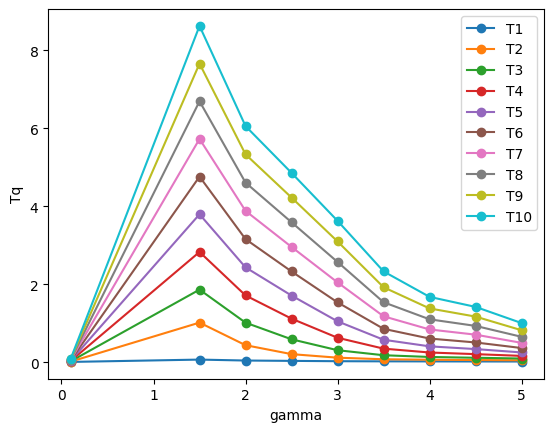

In [28]:
for i in nns:
    plt.plot(alphas, tns[i-1], marker='o', label=f'T{i}')
plt.xlabel('gamma')
plt.ylabel('Tq')
plt.legend()

# Mq - Xq

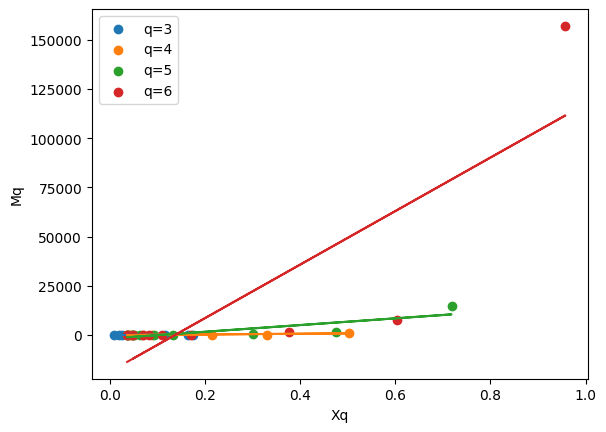

In [29]:
ms = []
for j in range(0,4):
    ms.append([ss[j][i]/NUM_OF_NODES for i in range(len(alphas))])
plt.scatter(xs[0], ms[0], label='q=3')
plt.scatter(xs[1], ms[1], label='q=4')
plt.scatter(xs[2], ms[2], label='q=5')
plt.scatter(xs[3], ms[3], label='q=6')
plt.plot(xs[0], get_regression_line(xs[0], ms[0]))
plt.plot(xs[1], get_regression_line(xs[1], ms[1]))
plt.plot(xs[2], get_regression_line(xs[2], ms[2]))
plt.plot(xs[3], get_regression_line(xs[3], ms[3]))
plt.xlabel('Xq')
plt.ylabel('Mq')
plt.legend()

# log Mq/N - Xq

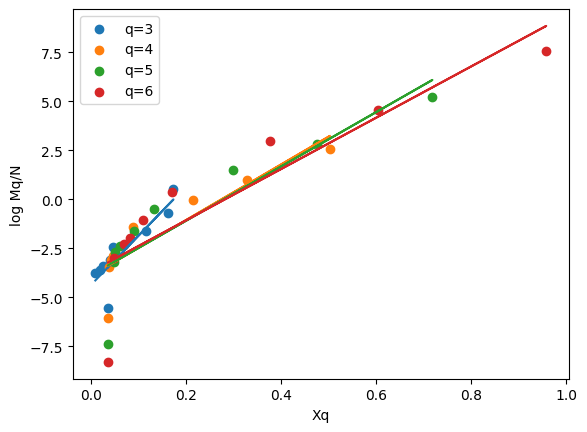

In [30]:
ms = []
for j in range(0,4):
    ms.append([ss[j][i]/(NUM_OF_NODES ** 2) for i in range(len(alphas))])
plt.scatter(xs[0], [math.log(x) for x in ms[0]], label='q=3')
plt.scatter(xs[1], [math.log(x) for x in ms[1]], label='q=4')
plt.scatter(xs[2], [math.log(x) for x in ms[2]], label='q=5')
plt.scatter(xs[3], [math.log(x) for x in ms[3]], label='q=6')
plt.plot(xs[0], get_regression_line(xs[0], [math.log(x) for x in ms[0]]))
plt.plot(xs[1], get_regression_line(xs[1], [math.log(x) for x in ms[1]]))
plt.plot(xs[2], get_regression_line(xs[2], [math.log(x) for x in ms[2]]))
plt.plot(xs[3], get_regression_line(xs[3], [math.log(x) for x in ms[3]]))
plt.xlabel('Xq')
plt.ylabel('log Mq/N')
plt.legend()

# log Mq/N - log Xq

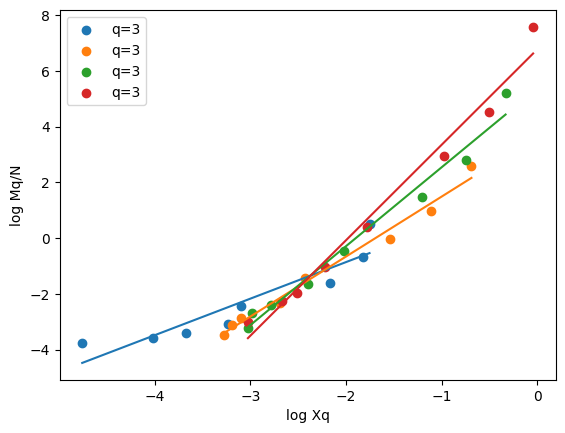

In [31]:
plt.scatter([math.log(x) for x in xs[0][1:]], [math.log(x) for x in ms[0][1:]], label='q=3')
plt.scatter([math.log(x) for x in xs[1][1:]], [math.log(x) for x in ms[1][1:]], label='q=3')
plt.scatter([math.log(x) for x in xs[2][1:]], [math.log(x) for x in ms[2][1:]], label='q=3')
plt.scatter([math.log(x) for x in xs[3][1:]], [math.log(x) for x in ms[3][1:]], label='q=3')
plt.plot([math.log(x) for x in xs[0][1:]], get_regression_line([math.log(x) for x in xs[0][1:]], [math.log(x) for x in ms[0][1:]]))
plt.plot([math.log(x) for x in xs[1][1:]], get_regression_line([math.log(x) for x in xs[1][1:]], [math.log(x) for x in ms[1][1:]]))
plt.plot([math.log(x) for x in xs[2][1:]], get_regression_line([math.log(x) for x in xs[2][1:]], [math.log(x) for x in ms[2][1:]]))
plt.plot([math.log(x) for x in xs[3][1:]], get_regression_line([math.log(x) for x in xs[3][1:]], [math.log(x) for x in ms[3][1:]]))
plt.xlabel('log Xq')
plt.ylabel('log Mq/N')
plt.legend()

# Multiplicity and Hamming Coefficient

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


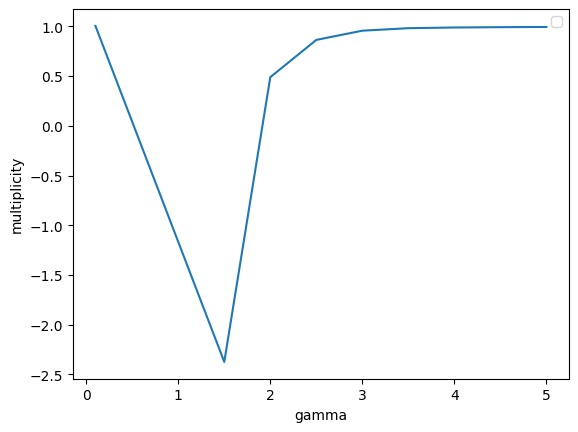

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


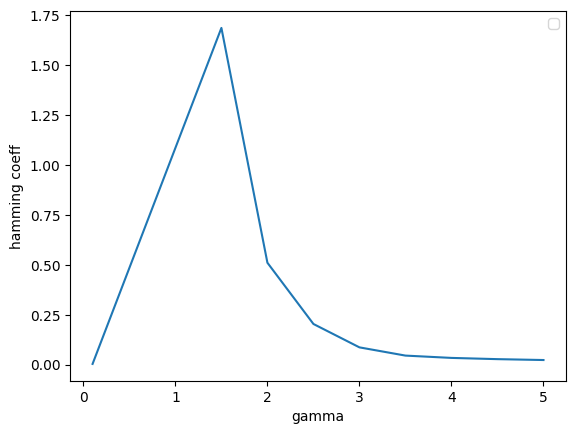

In [32]:
plt.plot(alphas, 1-(np.array(hcs)*(1/(np.array(alphas)-1))))
plt.xlabel('gamma')
plt.ylabel('multiplicity')
plt.legend()
plt.show()
plt.plot(alphas, hcs)
plt.xlabel('gamma')
plt.ylabel('hamming coeff')
plt.legend()

# Number of Cycles

Text(0, 0.5, 'number of cycles')

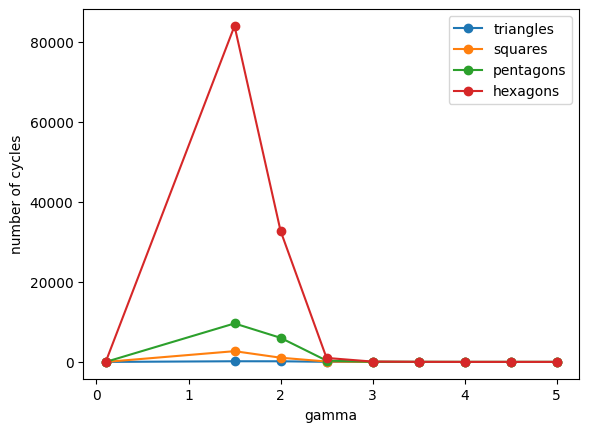

In [47]:
plt.plot(alphas, cycles[0], label="triangles", marker='o')
plt.plot(alphas, cycles[1], label="squares", marker='o')
plt.plot(alphas, cycles[2], label="pentagons", marker='o')
plt.plot(alphas, cycles[3], label="hexagons", marker='o')
plt.legend()
plt.xlabel('gamma')
plt.ylabel('number of cycles')